In [19]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
%load_ext autoreload
%autoreload 2

# Load and preprocess the data

In [4]:
from housing_prices_features import feature_engineering
from util import ProgressBarCallbackN, name_feature_importances

In [5]:
subdirectory = Path('housing-prices')
df_train = pd.read_csv(subdirectory / 'train.csv')
df_submit = pd.read_csv(subdirectory / 'test.csv')
df_train_fe = feature_engineering(df_train)
df_submit_fe = feature_engineering(df_submit)

print(df_train_fe.dtypes.value_counts())
print("Float: ",df_train_fe.select_dtypes(include=['float', 'float64', 'float32']).columns.tolist())
print("Object: ",df_train_fe.select_dtypes(include=['object']).columns.tolist())

Feature engineering housing transactions: rows 1460, columns before 81, columns after: 140
Feature engineering housing transactions: rows 1459, columns before 80, columns after: 139
int64      76
bool       48
object     17
float64     3
Name: count, dtype: int64
Float:  ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
Object:  ['Neighborhood', 'BldgType', 'RoofStyle', 'RoofMatl', 'Heating', 'Electrical', 'Functional', 'GarageType', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass_age', 'MSSubClass_type', 'HouseStyle_type', 'Exterior1st_material_type', 'MasVnrType_material_type']


# Review distributions

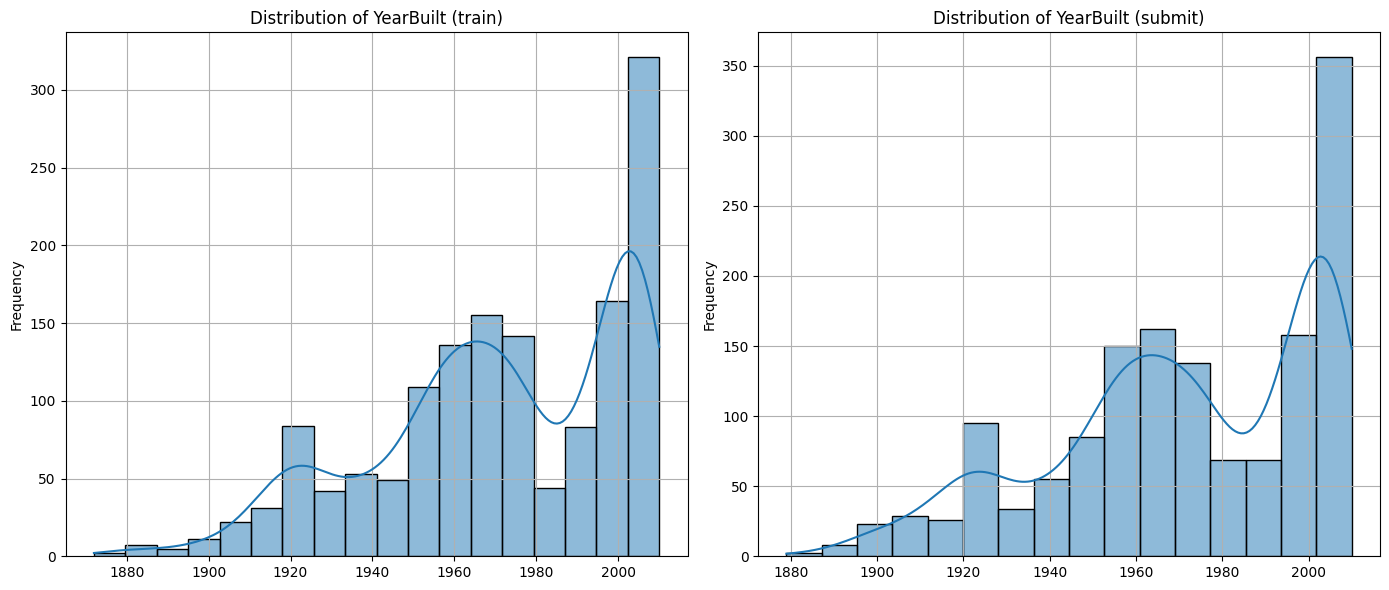

In [20]:
col  = 'YearBuilt'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df_train[col], kde=True, ax=axes[0])
axes[0].set_title(f'Distribution of {col} (train)')
axes[0].set_xlabel('')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

sns.histplot(df_submit[col], kde=True, ax=axes[1])
axes[1].set_title(f'Distribution of {col} (submit)')
axes[1].set_xlabel('')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [6]:
X = df_train_fe.drop(['SalePrice','Id'], axis=1)
y = df_train_fe['SalePrice']
ids = df_train_fe['Id']

X_submit = df_submit_fe.drop(['Id'], axis=1)
ids_submit = df_submit_fe['Id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_columns),
    ],
    remainder='passthrough'
)

lgbm_model = lgb.LGBMRegressor()

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', lgbm_model)
])

preprocessor_only = Pipeline([('preprocessor', preprocessor)])
X_test_transformed = preprocessor_only.fit_transform(X_test)

# Train LGBM model

In [ ]:
lgbm_params = {
    # Core parameters
    'n_estimators': 200,
    'learning_rate': 0.1,
    'max_depth': -1,
    'num_leaves': 25,
    'min_data_in_leaf': 30,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 3,

    # Regularization
    'lambda_l1': 0.3,
    'lambda_l2': 0.5,
    'min_gain_to_split': 0.1,
    'max_bin': 128,

    # Other important parameters
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    #'device': 'gpu',
    'verbose': -1,

    # early_stopping_rounds: 50
}

pipeline1 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(**lgbm_params))
])

pipeline1.fit(
    X,
    y,
    regressor__eval_set=[(X_test_transformed, y_test)],
    regressor__eval_metric='rmse',
)

In [ ]:
y_pred1 = pipeline1.predict(X_test)
y_submit = pipeline1.predict(X_submit)

mse = mean_squared_error(y_test, y_pred1)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred1)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

In [ ]:
submission = pd.DataFrame({
    'Id': ids_submit,
    'SalePrice': y_submit
})
submission.to_csv(subdirectory / 'housing-submission.csv', index=False)

# Optimize hyperparameters

In [ ]:
param_space = {
    'regressor__learning_rate': Real(0.08, 0.12, prior='log-uniform'),
    'regressor__n_estimators': Integer(250, 400),
    'regressor__max_depth': Categorical([3, 4, 5, 6]),
    'regressor__num_leaves': Integer(30, 60),
    'regressor__min_child_samples': Integer(2, 8),
    'regressor__subsample': Real(0.7, 0.9),
    'regressor__colsample_bytree': Real(0.2, 0.4),
    'regressor__reg_alpha': Real(0.001, 0.008, prior='log-uniform'),
    'regressor__reg_lambda': Real(0.8, 1.0, prior='log-uniform'),
    'regressor__bagging_freq': Integer(1, 3),
    'regressor__min_split_gain': Real(0.002, 0.01),
    'regressor__force_row_wise': Categorical([True])
}

n_iter = 400

bayes_search = BayesSearchCV(
    pipeline,
    param_space,
    n_iter=n_iter,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

fit_params = {
    'regressor__eval_set': [(X_test_transformed, y_test)],
}

progress_callback = ProgressBarCallbackN(n_iter, "Bayesian Optimization")

In [ ]:
bayes_search.fit(X, y, callback=progress_callback, **fit_params)

In [ ]:
bayes_search.best_params_

In [ ]:
y_pred = bayes_search.predict(X_test)
y_submit = bayes_search.predict(X_submit)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

In [ ]:
best_model = bayes_search.best_estimator_
fe_imp = best_model.named_steps['regressor'].feature_importances_
name_feature_importances(fe_imp, X_train.columns)

# Prepare outputs for submission

In [ ]:
submission = pd.DataFrame({
    'Id': ids_submit,
    'SalePrice': y_submit
})
submission.to_csv(subdirectory / 'housing-submission.csv', index=False)